# Quality Inspection - Machine Learning Models Benchmark - Xception

## Objective
To test the automation quality inspection using computer vision machine learning models
This repository will benchmark machine learning models (InceptionResNetv2, Xception, MobileNet and MobileNetV2) 

## Dataset

The dataset used is from from Pilot Technocast, a companyn located in Gujarat, India, that specializes in manufacturing casting products. The dataset, consisting of 7348 top-view images of submersible pump impellers made with stainless steel through a shell molding casting process, was made publicly available by Ravirajsinh Dabhi. The images were resized to 300 x 300 pixels and were collected using a Canon EOS 1300D camera kit under stable lighting. The data is pre-labeled into two categories, namely 'def_front' and 'ok_front,' representing defective and acceptable products, respectively.

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.preprocessing import image 
from keras.models import Sequential
from sklearn import metrics

2023-04-23 21:56:44.279139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Use the GPU on a Mac M1
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# defining dir variables 
root_dir = 'archive/casting_data/casting_data/'
train_defective = root_dir + 'train/def_front/'
train_ok = root_dir + 'train/ok_front/'

test_defective = root_dir + 'test/def_front/'
test_ok = root_dir + 'test/ok_front/'

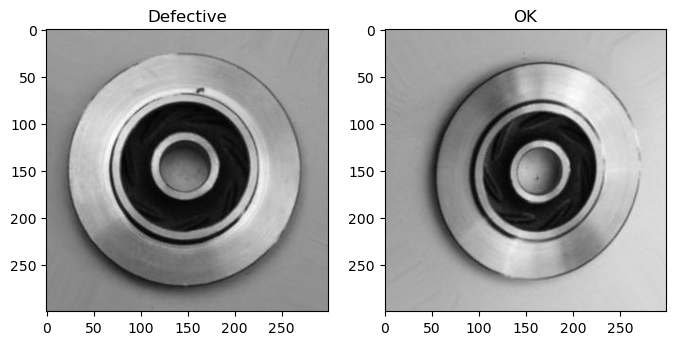

In [4]:
# Ploting images

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(plt.imread(train_defective+os.listdir(train_defective)[0]))
axes[1].imshow(plt.imread(train_ok+os.listdir(train_ok)[0]))
axes[0].set_title('Defective')
axes[1].set_title('OK')
plt.show()

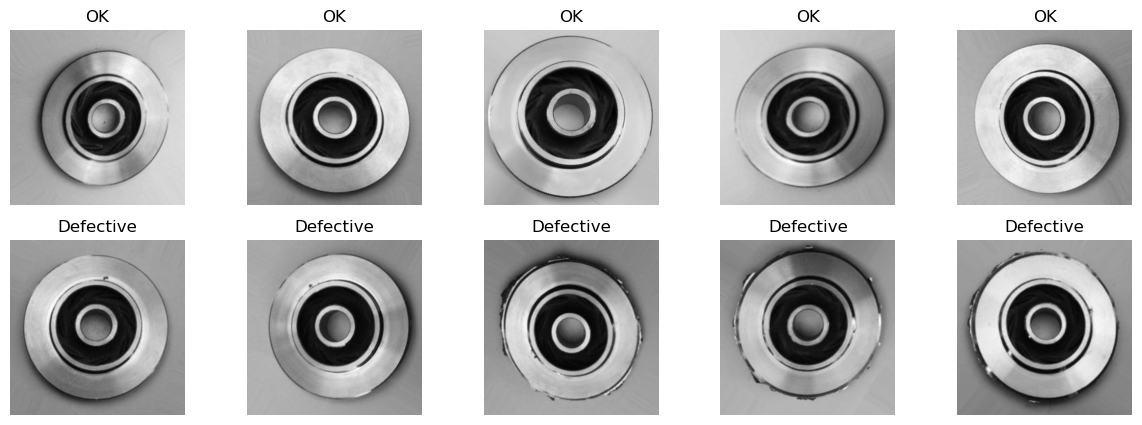

In [5]:
# 5 images from each label - training set

# define the number of images to plot for each label
num_images = 5

# create a figure with two rows and num_images columns
fig, axs = plt.subplots(nrows=2, ncols=num_images, figsize=(15,5))

# plot the ok images
for i, filename in enumerate(os.listdir(train_ok)[:num_images]):
    img = plt.imread(train_ok + filename)
    axs[0,i].imshow(img)
    axs[0,i].set_title('OK')
    axs[0,i].axis('off')

# plot the defective images
for i, filename in enumerate(os.listdir(train_defective)[:num_images]):
    img = plt.imread(train_defective + filename)
    axs[1,i].imshow(img)
    axs[1,i].set_title('Defective')
    axs[1,i].axis('off')

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# show the plot
plt.show()


### EDA(Exploratory data analysis)

    - Number of images

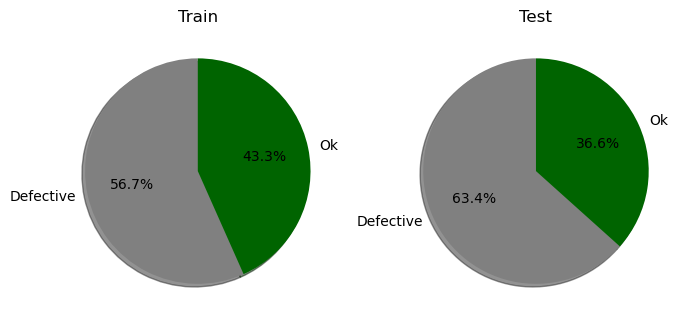

 Defective Training Images 	: 3758
 Ok Training Images 		: 2875

 Defective Testing Images 	: 453
 Ok Testing Images 		: 262


In [6]:
x_train = np.array([len(os.listdir(train_defective)),len(os.listdir(train_ok))])
x_test = np.array([len(os.listdir(test_defective)),len(os.listdir(test_ok))])
label = ['Defective','Ok']
colors = ['grey', 'darkgreen']
  
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

print(' Defective Training Images \t: ' + str(len(os.listdir(train_defective))))
print(' Ok Training Images \t\t: ' + str(len(os.listdir(train_ok))))
print()
print(' Defective Testing Images \t: ' + str(len(os.listdir(test_defective))))
print(' Ok Testing Images \t\t: ' + str(len(os.listdir(test_ok))))

## Data loading and perprocessing

    - Normalization 
    - input shape size for CNN (300x300)

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception


# Define the input shape of the images
input_shape = (300, 300, 3)

# Define the data generators for the training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'archive/casting_data/casting_data/train',
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='categorical',
    subset='training')

valid_generator = train_datagen.flow_from_directory(
    'archive/casting_data/casting_data/train',
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    'archive/casting_data/casting_data/test',
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='categorical')


Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


## CNN

### Bulding model

In [8]:
# Load the pre-trained MobileNetV1 model without the top layer
base_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a global average pooling layer and a dense output layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Define the model with the base model and the new layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with the Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-04-23 21:56:53.082771: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-23 21:56:53.082894: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

### Training

In [9]:

# Train the model with the training set and validate with the validation set
history = model.fit_generator(
    train_generator,
    steps_per_epoch=20,
    validation_data=valid_generator,
    epochs=20)

# Evaluate the model with the testing set
#test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples // test_generator.batch_size)
#print('Test accuracy:', test_acc)


Epoch 1/20


2023-04-23 21:57:41.153683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-23 21:57:43.172339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.6601 - accuracy: 0.6621

2023-04-23 21:58:58.189039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-23 21:58:59.240539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 183s 9s/step - loss: 0.6601 - accuracy: 0.6621 - val_loss: 0.5759 - val_accuracy: 0.5747
Epoch 2/20
20/20 [==============================] - 172s 9s/step - loss: 0.5184 - accuracy: 0.7716 - val_loss: 0.4693 - val_accuracy: 0.7773
Epoch 3/20
20/20 [==============================] - 169s 9s/step - loss: 0.4235 - accuracy: 0.8656 - val_loss: 0.3918 - val_accuracy: 0.8909
Epoch 4/20
20/20 [==============================] - 191s 10s/step - loss: 0.3608 - accuracy: 0.9250 - val_loss: 0.3376 - val_accuracy: 0.9221
Epoch 5/20
20/20 [==============================] - ETA: 0s - loss: 0.3011 - accuracy: 0.9445

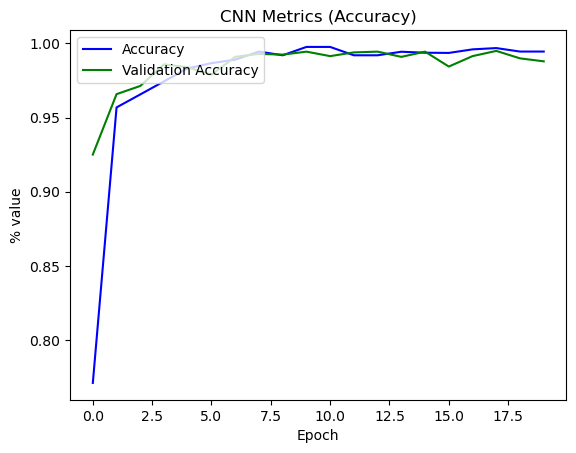

In [9]:
plt.plot(history.history['accuracy'], color='blue', label='Accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('CNN Metrics (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

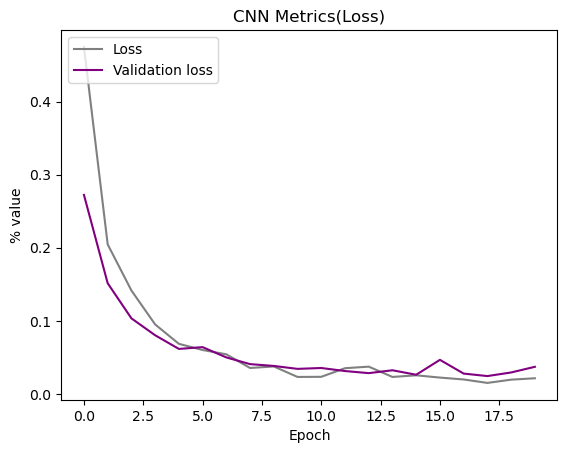

In [10]:
plt.plot(history.history['loss'], color='grey', label='Loss')
plt.plot(history.history['val_loss'], color='purple', label='Validation loss')
plt.title('CNN Metrics(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

### Testing and evaluation

In [23]:
y_pred = model.predict(test)
y_pred = (y_pred >= 0.5)

2023-04-23 11:17:56.961534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 21s 2s/step


In [24]:
y_actual = test.classes[test.index_array]

#### Confusion matrix

In [25]:
print(len(y_actual))
print(len(y_pred))

715
715


In [26]:
cm = metrics.confusion_matrix(y_actual, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='PuBuGn')
plt.show()

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

#### Classification report

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9956    0.9934    0.9945       453
           1     0.9886    0.9924    0.9905       262

    accuracy                         0.9930       715
   macro avg     0.9921    0.9929    0.9925       715
weighted avg     0.9930    0.9930    0.9930       715



In [ ]:
test_predictions = model.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(y_true=true_classes, y_pred=test_pred_classes)
print('Confusion matrix:\n', conf_matrix)